# MNIST Model

In [44]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self, mnist=True):
      
        super(Net, self).__init__()
        if mnist:
          num_channels = 1
        else:
          num_channels = 3
          
        self.conv1 = nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        if mnist:
          self.fc1 = nn.Linear(4*4*50, 500)
          self.flatten_shape = 4*4*50
        else:
          self.fc1 = nn.Linear(1250, 500)
          self.flatten_shape = 1250

        self.fc2 = nn.Linear(500, 10)
        
      
    def forward(self, x, vis=False, axs=None):
        X = 0
        y = 0

        if vis:
          axs[X,y].set_xlabel('Entry into network, input distribution visualised below: ')
          visualise(x, axs[X,y])

          axs[X,y+1].set_xlabel("Visualising weights of conv 1 layer: ")
          visualise(self.conv1.weight.data, axs[X,y+1])


        x = F.relu(self.conv1(x))

        if vis:
          axs[X,y+2].set_xlabel('Output after conv1 visualised below: ')
          visualise(x,axs[X,y+2])

          axs[X,y+3].set_xlabel("Visualising weights of conv 2 layer: ")
          visualise(self.conv2.weight.data, axs[X,y+3])

        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))

        if vis:
          axs[X,y+4].set_xlabel('Output after conv2 visualised below: ')
          visualise(x,axs[X,y+4])

          axs[X+1,y].set_xlabel("Visualising weights of fc 1 layer: ")
          visualise(self.fc1.weight.data, axs[X+1,y])

        x = F.max_pool2d(x, 2, 2)  
        x = x.view(-1, self.flatten_shape)
        x = F.relu(self.fc1(x))

        if vis:
          axs[X+1,y+1].set_xlabel('Output after fc1 visualised below: ')
          visualise(x,axs[X+1,y+1])

          axs[X+1,y+2].set_xlabel("Visualising weights of fc 2 layer: ")
          visualise(self.fc2.weight.data, axs[X+1,y+2])

        x = self.fc2(x)

        if vis:
          axs[X+1,y+3].set_xlabel('Output after fc2 visualised below: ')
          visualise(x,axs[X+1,y+3])

        return F.log_softmax(x, dim=1)
    

# Training 

In [5]:

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
   
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def main(mnist=True):
 
    batch_size = 64
    test_batch_size = 64
    epochs = 20
    lr = 0.005
    momentum = 0.5
    seed = 1
    log_interval = 500
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    if mnist:
      train_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=batch_size, shuffle=True, **kwargs)
      
      test_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
      transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

      trainset = datasets.CIFAR10(root='./dataCifar', train=True,
                                              download=True, transform=transform)
      train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)

      testset = datasets.CIFAR10(root='./dataCifar', train=False,
                                            download=True, transform=transform)
      test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                              shuffle=False, num_workers=2)
          
  
    model = Net(mnist=mnist).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    for epoch in range(1, epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")
    
    return model

model = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300039
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.524071

Test set: Average loss: 0.1619, Accuracy: 9518/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.260253
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.066542

Test set: Average loss: 0.0965, Accuracy: 9724/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.102955
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.048692

Test set: Average loss: 0.0773, Accuracy: 9751/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.046427
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.025560

Test set: Average loss: 0.0579, Accuracy: 9818/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.038110
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.082447

Test set: Average loss: 0.0514, Accuracy: 9831/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.193046
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.019089

Test set: Average loss: 0.0442, Accuracy: 9860/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.039848
Train Epoch: 7 [320

# Quantisation of Network

## Quantisation Functions

In [6]:
from collections import namedtuple
import torch
import torch.nn as nn

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits=8):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def calcScaleZeroPointSym(min_val, max_val,num_bits=8):
  
  # Calc Scale 
  max_val = max(abs(min_val), abs(max_val))
  qmin = 0.
  qmax = 2.**(num_bits-1) - 1.

  scale = max_val / qmax

  return scale, 0

def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

def quantize_tensor_sym(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    max_val = max(abs(min_val), abs(max_val))
    qmin = 0.
    qmax = 2.**(num_bits-1) - 1.

    scale = max_val / qmax   

    q_x = x/scale

    q_x.clamp_(-qmax, qmax).round_()
    q_x = q_x.round()
    return QTensor(tensor=q_x, scale=scale, zero_point=0)

def dequantize_tensor_sym(q_x):
    return q_x.scale * (q_x.tensor.float())

## Rework Forward pass of Linear and Conv Layers to support Quantisation

In [7]:
def quantizeLayer(x, layer, stat, scale_x, zp_x, vis=False, axs=None, X=None, y=None, sym=False, num_bits=8):
  # for both conv and linear layers

  # cache old values
  W = layer.weight.data
  B = layer.bias.data

  # WEIGHTS SIMULATED QUANTISED

  # quantise weights, activations are already quantised
  if sym:
    w = quantize_tensor_sym(layer.weight.data,num_bits=num_bits) 
    b = quantize_tensor_sym(layer.bias.data,num_bits=num_bits)
  else:
    w = quantize_tensor(layer.weight.data, num_bits=num_bits) 
    b = quantize_tensor(layer.bias.data, num_bits=num_bits)

  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  ## END WEIGHTS QUANTISED SIMULATION


  if vis:
    axs[X,y].set_xlabel("Visualising weights of layer: ")
    visualise(layer.weight.data, axs[X,y])

  # QUANTISED OP, USES SCALE AND ZERO POINT TO DO LAYER FORWARD PASS. (How does backprop change here ?)
  # This is Quantisation Arithmetic
  scale_w = w.scale
  zp_w = w.zero_point
  scale_b = b.scale
  zp_b = b.zero_point
  
  if sym:
    scale_next, zero_point_next = calcScaleZeroPointSym(min_val=stat['min'], max_val=stat['max'])
  else:
    scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Preparing input by saturating range to num_bits range.
  if sym:
    X = x.float()
    layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data)
    layer.bias.data = (scale_b/scale_next)*(layer.bias.data)
  else:
    X = x.float() - zp_x
    layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data - zp_w)
    layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

  # All int computation
  if sym:  
    x = (layer(X)) 
  else:
    x = (layer(X)) + zero_point_next 
  
  # cast to int
  x.round_()

  # Perform relu too
  x = F.leaky_relu(x)

  # Reset weights for next forward pass
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next


## Get Stats for Quantising Activations of Network.

This is done by running the network with around 1000 examples and getting the average min and max activation values before and after each layer.

In [8]:
# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)

  # add ema calculation

  if key not in stats:
    stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    stats[key]['total'] += 1
  
  weighting = 2.0 / (stats[key]['total']) + 1

  if 'ema_min' in stats[key]:
    stats[key]['ema_min'] = weighting*(min_val.mean().item()) + (1- weighting) * stats[key]['ema_min']
  else:
    stats[key]['ema_min'] = weighting*(min_val.mean().item())

  if 'ema_max' in stats[key]:
    stats[key]['ema_max'] = weighting*(max_val.mean().item()) + (1- weighting) * stats[key]['ema_max']
  else: 
    stats[key]['ema_max'] = weighting*(max_val.mean().item())

  stats[key]['min_val'] = stats[key]['min']/ stats[key]['total']
  stats[key]['max_val'] = stats[key]['max']/ stats[key]['total']
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
  
  x = F.relu(model.conv1(x))

  x = F.max_pool2d(x, 2, 2)
  
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
  
  x = F.relu(model.conv2(x))

  x = F.max_pool2d(x, 2, 2)

  x = x.view(-1, 4*4*50)
  
  stats = updateStats(x, stats, 'fc1')

  x = F.relu(model.fc1(x))
  
  stats = updateStats(x, stats, 'fc2')

  x = model.fc2(x)

  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    device = 'cuda'
    
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)
    
    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"], "ema_min": value["ema_min"], "ema_max": value["ema_max"] }
    return final_stats

## Forward Pass for Quantised Inference

In [9]:
def quantForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8):
  X = 0
  y = 0
  # Quantise before inputting into incoming layers
  if sym:
    x = quantize_tensor_sym(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)
  else:
    x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)

  if vis:
    axs[X,y].set_xlabel('Entry into network, input distribution visualised below: ')
    visualise(x.tensor, axs[X,y])
  
  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv1, stats['conv2'], x.scale, x.zero_point, vis, axs, X=X, y=y+1, sym=sym, num_bits=num_bits)

  x = F.max_pool2d(x, 2, 2)
  
  if vis:
    axs[X,y+2].set_xlabel('Output after conv1 visualised below: ')
    visualise(x,axs[X,y+2])

  x, scale_next, zero_point_next = quantizeLayer(x, model.conv2, stats['fc1'], scale_next, zero_point_next, vis, axs, X=X, y=y+3, sym=sym, num_bits=num_bits)

  x = F.max_pool2d(x, 2, 2)

  if vis:
    axs[X,y+4].set_xlabel('Output after conv2 visualised below: ')
    visualise(x,axs[X,y+4])

  x = x.view(-1, 4*4*50)

  x, scale_next, zero_point_next = quantizeLayer(x, model.fc1, stats['fc2'], scale_next, zero_point_next, vis, axs, X=X+1, y=0, sym=sym, num_bits=num_bits)

  if vis:
    axs[X+1,1].set_xlabel('Output after fc1 visualised below: ')
    visualise(x,axs[X+1,1])
  
  # Back to dequant for final layer
  if sym:
    x = dequantize_tensor_sym(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
  else:
    x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))

  if vis:
    axs[X+1,2].set_xlabel('Output after fc1 but dequantised visualised below: ')
    visualise(x,axs[X+1,2])

  x = model.fc2(x)

  if vis:
    axs[X+1,3].set_xlabel('Unquantised Weights of fc2 layer')
    visualise(model.fc2.weight.data,axs[X+1,3])

    axs[X+1,2].set_xlabel('Output after fc2 but dequantised visualised below: ')
    visualise(x,axs[X+1,4])

  return F.log_softmax(x, dim=1)

# Testing Function for Quantisation

In [10]:
def testQuant(model, test_loader, quant=False, stats=None, sym=False, num_bits=8):
    device = 'cuda'
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if quant:
              output = quantForward(model, data, stats, sym=sym, num_bits=num_bits)
            else:
              output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Get Accuracy of Non Quantised Model

In [11]:
import copy
q_model = copy.deepcopy(model)

In [12]:
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

In [13]:
testQuant(q_model, test_loader, quant=False)


Test set: Average loss: 0.0301, Accuracy: 9903/10000 (99%)



# Gather Stats of Activations

In [14]:
stats = gatherStats(q_model, test_loader)
print(stats)

{'conv1': {'max': tensor(179.6298, device='cuda:0'), 'min': tensor(-27.0200, device='cuda:0'), 'ema_min': -0.4242129623889923, 'ema_max': 2.81828204412248}, 'conv2': {'max': tensor(628.9142, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'ema_min': 0.0, 'ema_max': 10.00134922050808}, 'fc1': {'max': tensor(1140.2422, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'ema_min': 0.0, 'ema_max': 17.742369543779294}, 'fc2': {'max': tensor(624.6760, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'ema_min': 0.0, 'ema_max': 9.2946570098729}}


# Test Quantised Inference Of Model

In [15]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=False, num_bits=6)


Test set: Average loss: 0.1154, Accuracy: 9651/10000 (97%)



In [16]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=True, num_bits=8)


Test set: Average loss: 0.1084, Accuracy: 9681/10000 (97%)



In [17]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=True, num_bits=4)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)



See, when we go down to 4 bits, the accuracy craters !

# Visualise Weights and Activations

In [18]:
def visualise(x, axs):
  x = x.view(-1).cpu().numpy()
  axs.hist(x) 

## Visualise Quantised Model

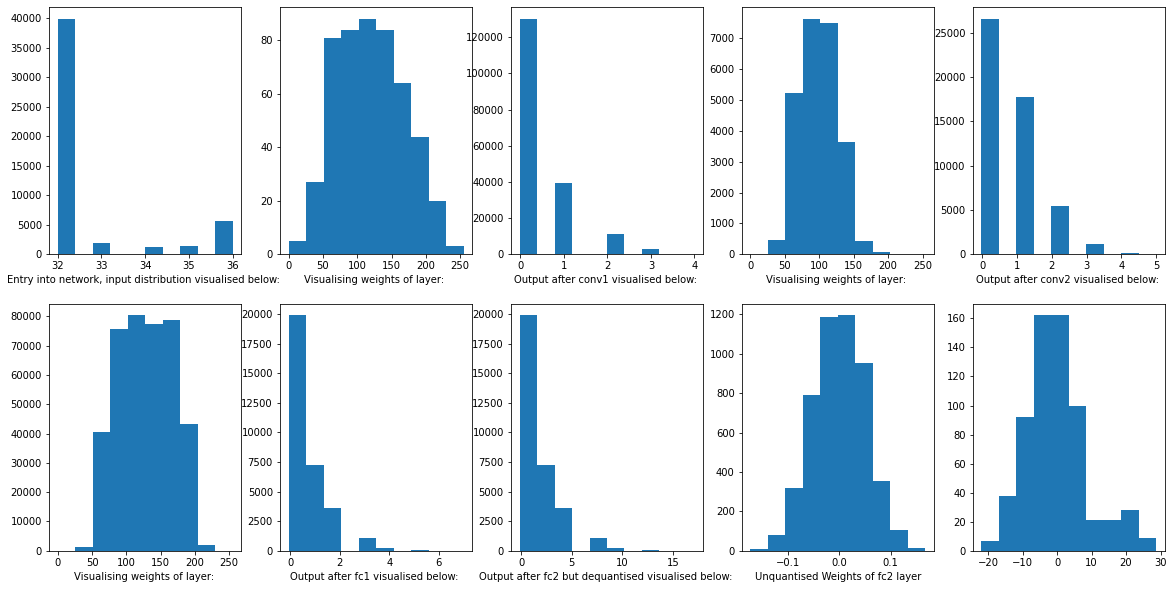

In [19]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True, axs=axs, sym=False)
        break
plt.show()

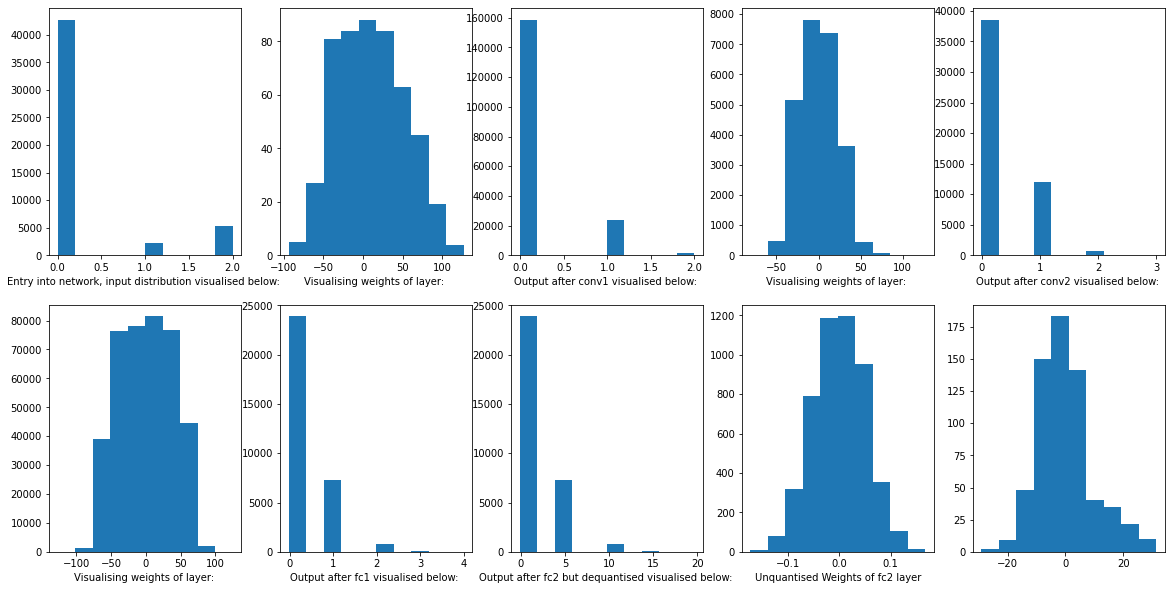

In [20]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True, axs=axs, sym=True)
        break
plt.show()

## Non Quantised Network weights and activations

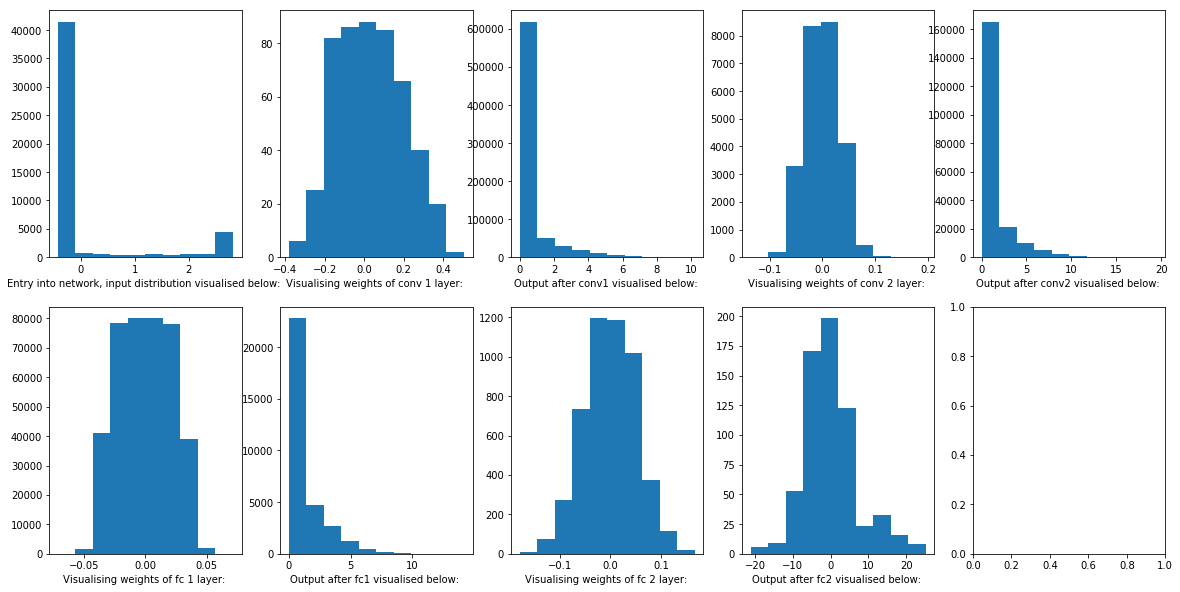

In [ ]:
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data, vis=True, axs=axs)
        break
plt.show()

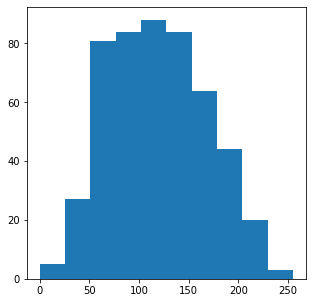

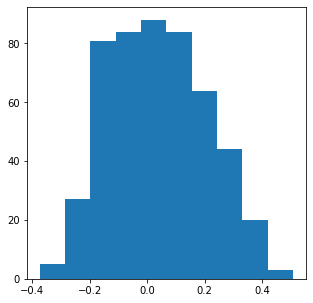

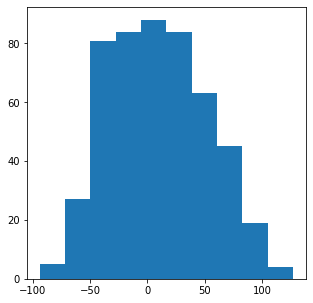

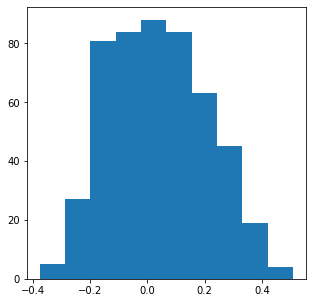

In [21]:
quantisedConv1 = quantize_tensor(model.conv1.weight.data)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(quantisedConv1.tensor.cpu().view(-1).numpy())

plt.show()

quantisedConv1 = model.conv1.weight.data
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(quantisedConv1.cpu().view(-1).numpy())

plt.show()

quantisedConv1 = quantize_tensor_sym(model.conv1.weight.data)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(quantisedConv1.tensor.cpu().view(-1).numpy())

plt.show()

unquantisedConv1 = dequantize_tensor_sym(quantisedConv1)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(unquantisedConv1.cpu().view(-1).numpy())

plt.show()

## TA DA !!

We have quantised our net to mostly 8 bit arithmetic with almost zero accuracy loss ! Pretty good day's work, I'll say :D

# Quantisation Aware Training

In [22]:
import torch

class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_bits=8, min_val=None, max_val=None):
        x = quantize_tensor(x,num_bits=num_bits, min_val=min_val, max_val=max_val)
        x = dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

In [23]:
x = torch.tensor([1,2,3,4]).float()
print(FakeQuantOp.apply(x))

tensor([1., 2., 3., 3.])


## Quantization Aware Training Forward Pass

In [24]:
def quantAwareTrainingForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8, act_quant=False):
  
  conv1weight = model.conv1.weight.data
  model.conv1.weight.data = FakeQuantOp.apply(model.conv1.weight.data, num_bits)
  x = F.relu(model.conv1(x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv1']['ema_min'], stats['conv1']['ema_max'])

  x = F.max_pool2d(x, 2, 2)

  conv2weight = model.conv2.weight.data
  model.conv2.weight.data = FakeQuantOp.apply(model.conv2.weight.data, num_bits)
  x = F.relu(model.conv2(x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
    
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv2']['ema_min'], stats['conv2']['ema_max'])


  x = F.max_pool2d(x, 2, 2)

  x = x.view(-1, 4*4*50)

  fc1weight = model.fc1.weight.data
  model.fc1.weight.data = FakeQuantOp.apply(model.fc1.weight.data, num_bits)
  x = F.relu(model.fc1(x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc1')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['fc1']['ema_min'], stats['fc1']['ema_max'])

  x = model.fc2(x)
  
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc2')

  return F.log_softmax(x, dim=1), conv1weight, conv2weight, fc1weight, stats

# Train using Quantization Aware Training

In [25]:
def trainQuantAware(args, model, device, train_loader, optimizer, epoch, stats, act_quant=False, num_bits=4):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, conv1weight, conv2weight, fc1weight, stats = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=act_quant)

        model.conv1.weight.data = conv1weight
        model.conv2.weight.data = conv2weight
        model.fc1.weight.data = fc1weight

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return stats

def testQuantAware(args, model, device, test_loader, stats, act_quant, num_bits=4):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, conv1weight, conv2weight, fc1weight, _ = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=act_quant)
            
            model.conv1.weight.data = conv1weight
            model.conv2.weight.data = conv2weight
            model.fc1.weight.data = fc1weight

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def mainQuantAware(mnist=True):
 
    batch_size = 64
    test_batch_size = 64
    epochs = 20
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 500
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    if mnist:
      train_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=batch_size, shuffle=True, **kwargs)
      
      test_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
      transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

      trainset = datasets.CIFAR10(root='./dataCifar', train=True,
                                              download=True, transform=transform)
      train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)

      testset = datasets.CIFAR10(root='./dataCifar', train=False,
                                            download=True, transform=transform)
      test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                              shuffle=False, num_workers=2)
          
  
    model = Net(mnist=mnist).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    epochs = 20
    num_bits=8
    stats = {}
    for epoch in range(1, epochs + 1):
        if epoch > 5:
          act_quant = True 
        else:
          act_quant = False

        stats = trainQuantAware(args, model, device, train_loader, optimizer, epoch, stats, act_quant, num_bits=num_bits)
        testQuantAware(args, model, device, test_loader, stats, act_quant, num_bits=num_bits)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

    return model, stats

model, old_stats = mainQuantAware()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300226
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.342062

Test set: Average loss: 0.1018, Accuracy: 9663/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.145594
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.033506

Test set: Average loss: 0.0611, Accuracy: 9826/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.052354
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.028835

Test set: Average loss: 0.0569, Accuracy: 9807/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.018603
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.015321

Test set: Average loss: 0.0414, Accuracy: 9864/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.010301
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.041269

Test set: Average loss: 0.0382, Accuracy: 9876/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.122685
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.012870

Test set: Average loss: 0.0335, Accuracy: 9892/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.029352
Train Epoch: 7 [320

# Test Quantization Aware Training

In [26]:
def testQuantAware(model, test_loader, stats=None, sym=False, num_bits=8):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, conv1weight, conv2weight, fc1weight, _ = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=True, sym=False)
            
            model.conv1.weight.data = conv1weight
            model.conv2.weight.data = conv2weight
            model.fc1.weight.data = fc1weight

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Load Dataset

In [27]:
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

## Test Quant Aware 

In [28]:
print(old_stats)

{'conv1': {'max': tensor(12342376., device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 21900, 'ema_min': 0.0, 'ema_max': 10.032305866558502, 'min_val': tensor(0., device='cuda:0'), 'max_val': tensor(563.5789, device='cuda:0')}, 'conv2': {'max': tensor(21562654., device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 21900, 'ema_min': 0.0, 'ema_max': 18.264613489636574, 'min_val': tensor(0., device='cuda:0'), 'max_val': tensor(984.5961, device='cuda:0')}, 'fc1': {'max': tensor(11720262., device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 21900, 'ema_min': 0.0, 'ema_max': 10.869163509818787, 'min_val': tensor(0., device='cuda:0'), 'max_val': tensor(535.1718, device='cuda:0')}, 'fc2': {'max': tensor(22082518., device='cuda:0'), 'min': tensor(-13815383., device='cuda:0'), 'total': 21900, 'ema_min': -11.220185884749975, 'ema_max': 20.37988847299026, 'min_val': tensor(-630.8394, device='cuda:0'), 'max_val': tensor(1008.3342, device='cuda:0')}}


In [29]:
import copy
q_model = copy.deepcopy(model)

In [30]:
testQuantAware(q_model, test_loader, stats=old_stats, sym=False, num_bits=8)


Test set: Average loss: 0.0285, Accuracy: 9906/10000 (99%)



## Voila

We're back to test accuracy.

# Vis 2 bit Model Weights

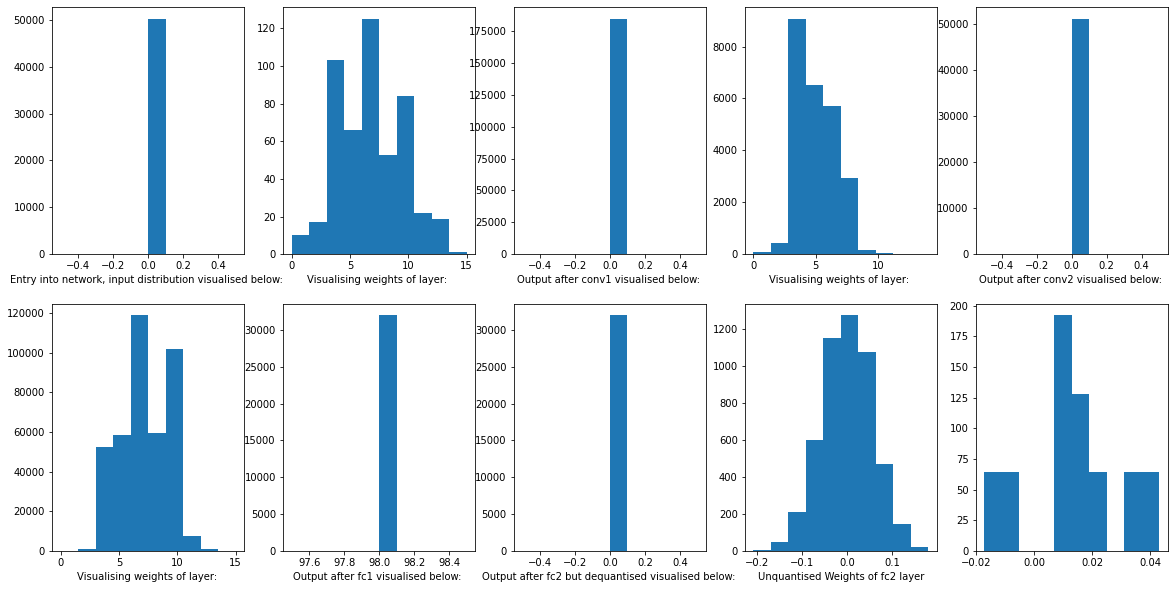

In [31]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        quantForward(q_model, data, old_stats, vis=True, axs=axs, sym=False, num_bits=4)
#         output = quantAwareTrainingForward(q_model, data, old_stats, vis=True, axs=axs, sym=False, num_bits=2, act_quant=True)
        break
plt.show()

## Quantization Aware with Noise during forward prop

### Forward Pass; (this function is not called. I was just using it to test randomized factor)

In [81]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

# redefine the nn.Module with a random gaussian term 

class NetMem(nn.Module):
    def __init__(self, mnist=True):
      
        super(NetMem, self).__init__()
        if mnist:
          num_channels = 1
        else:
          num_channels = 3
          
        self.conv1 = nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        if mnist:
          self.fc1 = nn.Linear(4*4*50, 500)
          self.flatten_shape = 4*4*50
        else:
          self.fc1 = nn.Linear(1250, 500)
          self.flatten_shape = 1250

        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x, vis=False, axs=None):
        X = 0
        y = 0

        if vis:
          axs[X,y].set_xlabel('Entry into network, input distribution visualised below: ')
          visualise(x, axs[X,y])

          axs[X,y+1].set_xlabel("Visualising weights of conv 1 layer: ")
          visualise(self.conv1.weight.data, axs[X,y+1])

        memristor_dist1 = torch.normal(1, 0.02, size = self.conv1.weight.data.size())
        x = F.relu(self.conv1(x)*memristor_dist1)

        if vis:
          axs[X,y+2].set_xlabel('Output after conv1 visualised below: ')
          visualise(x,axs[X,y+2])

          axs[X,y+3].set_xlabel("Visualising weights of conv 2 layer: ")
          visualise(self.conv2.weight.data, axs[X,y+3])

        x = F.max_pool2d(x, 2, 2)

        memristor_dist2 = torch.normal(1, 0.02, size = self.conv2.weight.data.size())
        x = F.relu(self.conv2(x)*memristor_dist2)

        if vis:
          axs[X,y+4].set_xlabel('Output after conv2 visualised below: ')
          visualise(x,axs[X,y+4])

          axs[X+1,y].set_xlabel("Visualising weights of fc 1 layer: ")
          visualise(self.fc1.weight.data, axs[X+1,y])

        x = F.max_pool2d(x, 2, 2)  
        x = x.view(-1, self.flatten_shape)

        memristor_dist3 = torch.normal(1, 0.02, size = self.fc1.weight.data.size())
        x = F.relu(self.fc1(x)*memristor_dist3)

        if vis:
          axs[X+1,y+1].set_xlabel('Output after fc1 visualised below: ')
          visualise(x,axs[X+1,y+1])

          axs[X+1,y+2].set_xlabel("Visualising weights of fc 2 layer: ")
          visualise(self.fc2.weight.data, axs[X+1,y+2])

        memristor_dist4 = torch.normal(1, 0.02, size = self.fc2.weight.data.size())
        x = self.fc2(x)*memristor_dist4

        if vis:
          axs[X+1,y+3].set_xlabel('Output after fc2 visualised below: ')
          visualise(x,axs[X+1,y+3])

        return F.log_softmax(x, dim=1)
           
      

# Quantization aware forward pass with memristor noise
The noise is of Gaussian Dist. mean 1.0 and var of 2%. There is a good chance the distribution is recalculated each time. It could make more sense to set memristor_dist1-4 globally, and re-use that every time.

In [205]:
def quantAwareTrainingForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8, act_quant=False):
  
  conv1weight = model.conv1.weight.data
  model.conv1.weight.data = FakeQuantOp.apply(model.conv1.weight.data, num_bits)

  #print("The size of x is: {}".format(x.size()))
  #print("The size of conv1 is: {}".format(model.conv1.weight.data.size()))
  a = x.size()[0]
  b = model.conv1.weight.data.size()[0]

  memristor_dist1 = torch.normal(1, 0.02, size = [int(a), int(b), 24, 24]).to(device)
  x = F.relu(model.conv1(x)*memristor_dist1)

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv1']['ema_min'], stats['conv1']['ema_max'])

  x = F.max_pool2d(x, 2, 2)

  conv2weight = model.conv2.weight.data
  model.conv2.weight.data = FakeQuantOp.apply(model.conv2.weight.data, num_bits)

  #print("The size of x is: {}".format(x.size()))
  #print("The size of conv2 is: {}".format(model.conv1.weight.data.size()))

  a = x.size()[0]
  b = model.conv2.weight.data.size()[0]
  memristor_dist2 = torch.normal(1, 0.02, size = [int(a), int(b), 8, 8]).to(device)
  x = F.relu(model.conv2(x)*memristor_dist2)

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
    
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv2']['ema_min'], stats['conv2']['ema_max'])


  x = F.max_pool2d(x, 2, 2)
  x = x.view(-1, 4*4*50)

  fc1weight = model.fc1.weight.data
  model.fc1.weight.data = FakeQuantOp.apply(model.fc1.weight.data, num_bits)
  #print("fc1weight size is: {}".format(fc1weight.size()))

  #print("The size of x is: {}".format(x.size()))
  #print("The size of conv2 is: {}".format(model.fc1.weight.data.size()))

  a = x.size()[0]
  b = model.fc1.weight.data.size()[0]

  #print("The size of a at fc1 is: {}".format(a)) #should be 64
  #print("The size of b at fc1 is: {}".format(b)) # should be 500
  
  memristor_dist3 = torch.normal(1, 0.02, size = [int(a), int(b)]).to(device)
  x = F.relu(model.fc1(x)*memristor_dist3)
  #print("x after fc1 is: {}".format(x.size()))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc1')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['fc1']['ema_min'], stats['fc1']['ema_max'])

  a = x.size()[0]
  b = model.fc2.weight.data.size()[0]

  memristor_dist4 = torch.normal(1, 0.02, size = [int(a), int(b)]).to(device)
  x = model.fc2(x)*memristor_dist4
  #print("x after fc2 is: {}".format(x.size()))
  
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc2')

  return F.log_softmax(x, dim=1), conv1weight, conv2weight, fc1weight, stats

In [206]:
def trainQuantAware(args, model, device, train_loader, optimizer, epoch, stats, act_quant=False, num_bits=8):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, conv1weight, conv2weight, fc1weight, stats = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=act_quant)

        model.conv1.weight.data = conv1weight
        model.conv2.weight.data = conv2weight
        model.fc1.weight.data = fc1weight

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return stats

def testQuantAware(args, model, device, test_loader, stats, act_quant, num_bits=8):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, conv1weight, conv2weight, fc1weight, _ = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=act_quant)
            
            model.conv1.weight.data = conv1weight
            model.conv2.weight.data = conv2weight
            model.fc1.weight.data = fc1weight

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def mainQuantAware(mnist=True):
 
    batch_size = 64
    test_batch_size = 64
    epochs = 20
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 500
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    if mnist:
      train_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=batch_size, shuffle=True, **kwargs)
      
      test_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
      transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

      trainset = datasets.CIFAR10(root='./dataCifar', train=True,
                                              download=True, transform=transform)
      train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)

      testset = datasets.CIFAR10(root='./dataCifar', train=False,
                                            download=True, transform=transform)
      test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                              shuffle=False, num_workers=2)
          
  
    model = NetMem(mnist=mnist).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    epochs = 20
    num_bits=8
    stats = {}
    for epoch in range(1, epochs + 1):
        if epoch > 5:
          act_quant = True 
        else:
          act_quant = False

        stats = trainQuantAware(args, model, device, train_loader, optimizer, epoch, stats, act_quant, num_bits=num_bits)
        testQuantAware(args, model, device, test_loader, stats, act_quant, num_bits=num_bits)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

    return model, stats

model, old_stats = mainQuantAware()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300277
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.339051

Test set: Average loss: 0.1018, Accuracy: 9669/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.074770
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.160223

Test set: Average loss: 0.0673, Accuracy: 9800/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.050186
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.049337

Test set: Average loss: 0.0507, Accuracy: 9840/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.139028
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.162087

Test set: Average loss: 0.0577, Accuracy: 9824/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.035885
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.023171

Test set: Average loss: 0.0411, Accuracy: 9870/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.069465
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.093299

Test set: Average loss: 0.0342, Accuracy: 9887/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.019616
Train Epoch: 7 [320